# Orangutan Organoid Scanpy

~15000 Cells from a 10x run. Basic analysis along with trying out my new implementation of RNA velocity analysis. This includes:
Filtering, normalizing, dimension reduction, louvain clustering, DE, gene set scoring, and RNA velocity.

In [1]:
%matplotlib inline

import matplotlib
#matplotlib.use('agg') # plotting backend compatible with screen
import scanpy
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging as logg
import os
import loompy
import scipy
import re
import anndata
import random
import sklearn
results_file = os.path.expanduser('~/Desktop//home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/processedOrangutanOrganoidScanpy.h5ad')

/home/mt/code/utils/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/outs/raw_gene_bc_matrices_h5.h5','refdata-cellranger-Pabe3_20180719')

#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
sc.tl.addCleanObsNames(adata)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/outs/raw_gene_bc_matrices_h5.h5','refdata-cellranger-Pabe3_20180719')
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
sc.tl.addCleanObsNames(adata)
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=15)

sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata,min_cells=70)
print(adata)

from sklearn import semi_supervised
from sklearn import linear_model
import umi_tools
#mito_genes = [name for name in adata.var_names if name in ['ND1','ND2','ND4L','ND4','ND5','ND6','ATP6','ATP8','CYTB','COX1','COX2','COX3']]
mito_genes = [name for name in adata.var_names if name.startswith(('MTND','MTCO','MTATP','MTCYB','MTRNR','MTTR',))]
ribo_genes = [name for name in adata.var_names if name.startswith('RPS') or name.startswith('RPL') ]

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
scanpy.api.pp.filter_genes_dispersion(adata,n_top_genes=np.sum(np.sum(adata.X, axis=0)>0))

adata=adata[adata.obs.n_counts.argsort()[::-1],:]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
AnnData object with n_obs × n_vars = 6119 × 5238 
    obs: 'clean_obs_names', 'n_genes'
    var: 'gene_ids', 'n_cells'


In [59]:
from sklearn import decomposition
ldaM=sklearn.decomposition.LatentDirichletAllocation(n_components=10,topic_word_prior=.5,learning_method="online",verbose=1)

In [60]:
ldaM.fit(adata.X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=0.5,
             total_samples=1000000.0, verbose=1)

In [61]:
doc_topic=ldaM.transform(adata.X)

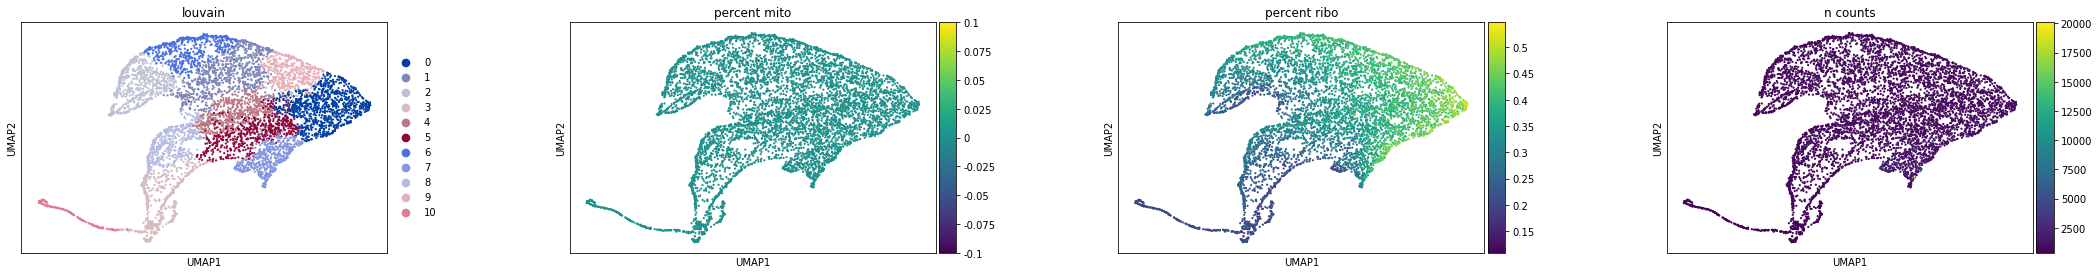

In [64]:
neighbors=sc.Neighbors(anndata.AnnData(doc_topic))
neighbors.compute_neighbors(n_neighbors=100,use_rep='X',metric="manhattan")
adata.uns['neighbors'] = {}
adata.uns['neighbors']['distances'] = neighbors.distances
adata.uns['neighbors']['connectivities'] = neighbors.connectivities
sc.tl.louvain(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["louvain","percent_mito",'percent_ribo',"n_counts"])

In [5]:
import gensim
from gensim import sklearn_api
def moving_average(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return(ma_vec)
def table_top_words(model, feature_names, n_top_words):
    df=[]
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx)
        df.append([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(df)
    return(pd.DataFrame(df))

#A bit of a hack because normally this is returned nice and sparse, but you don't know which topics are included
def get_doc_topic(corpus, model,eps=0):
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
    return np.array(doc_topic)[:,:,1]
'''
###THIS DOESNT WORK
def get_doc_topic(corpus, model,eps=0.0):
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
        #Convert index,value tuples to sparse matrix, then dense
    i, j, data = zip(*((i, t[0], t[1]) for i, row in enumerate(doc_topic) for t in row))
    return(scipy.sparse.csr_matrix((data, (i, j))).todense(),list(set(j)))

'''
#Works, slow, only method that works
def get_doc_topic(corpus, model,eps=0.0):
    import itertools
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
        #Convert index,value tuples to sparse matrix, then dense
    ii=[[i]*len(v) for i,v in enumerate(doc_topic)]
    ii=list(itertools.chain(*ii))
    jj=[j for j,_ in itertools.chain(*doc_topic)]
    data=[d for _,d in itertools.chain(*doc_topic)]
    return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))


def get_topic_to_wordids(model):
    p = list()
    if hasattr(model, 'm_T'):
        ran=range(model.m_T)
    else:
        ran=range(model.num_topics)
    for topicid in ran:
        topic = model.m_lambda[topicid]
        topic = topic / topic.sum() # normalize to probability dist
        p.append(topic)

    return np.array(p).T
#Merges 2 2D dataframes into 3d, then collapses them every other column (Name1,Val1,Name2,Val2)
def table_top_words(word_topic, feature_names):
    return(pd.DataFrame(np.stack([feature_names[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)))

adata=adata[:,adata.var.index.argsort()]
model = gensim.models.LdaModel(corpus=gensim.matutils.Sparse2Corpus( adata.X.T),id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),num_topics=10)
adata.uns['gensim_lda_model']=model
#doc_topic=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)
doc_topic,included=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)
neighbors=sc.Neighbors(anndata.AnnData(doc_topic))
neighbors.compute_neighbors(n_neighbors=100,use_rep='X',metric="manhattan")
adata.uns['neighbors'] = {}
adata.uns['neighbors']['distances'] = neighbors.distances
adata.uns['neighbors']['connectivities'] = neighbors.connectivities
sc.tl.louvain(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["louvain","percent_mito",'percent_ribo',"n_counts"])

'pattern' package not found; tag filters are not available for English
adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(5238 unique tokens: ['AAAS', 'AAGAB', 'AAMP', 'AARS', 'AASDH']...) from 1 documents (total 5238 corpus positions)
using symmetric alpha at 0.1
using symmetric eta at 0.1
using serial LDA version on this node
running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 6119 documents, updating model once every 2000 documents, evaluating perplexity every 6119 documents, iterating 50x with a convergence threshold of 0.001000
too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
PROGRESS: pass 0, at document #2000/6119
merging changes from 2000 documents into a model of 6119 documents
topic #6 (0.100): 0.142*"MALAT1" + 0.020*"RPL39" + 0.019*"RPS27" + 0.018*"RPS19" + 0.018*"RPL7" + 0.018*"RPL34" + 0.017*"RPL21" + 0.013*"RPL41" + 0.009*"FTL" + 0.008*"RPL32"

KeyboardInterrupt: 

In [13]:
def sc_hdp(adata,alpha=1,eta=.01,gamma=1,eps=1e-5,save=False):
    import gensim
    import scipy
    import itertools
    def moving_average(data,window_width):
        cumsum_vec = np.cumsum(np.insert(data, 0, 0))
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        return(ma_vec)

    def table_top_words(word_topic, feature_names, n_top_words):
        df=[]
        for topic_idx, topic in enumerate(word_topic):
            print(topic_idx)
            df.append([feature_names[i]
                                for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(df)
        return(pd.DataFrame(df))

    #A bit of a hack because normally this is returned nice and sparse, but you don't know which topics are included
    #Works, slow, only method that works
    def get_doc_topic(corpus, model,eps=0.0):
        doc_topic = list()
        for doc in corpus:
            doc_topic.append(model.__getitem__(doc, eps=eps))
            #Convert index,value tuples to sparse matrix, then dense
        ii=[[i]*len(v) for i,v in enumerate(doc_topic)]
        ii=list(itertools.chain(*ii))
        jj=[j for j,_ in itertools.chain(*doc_topic)]
        data=[d for _,d in itertools.chain(*doc_topic)]
        return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))


    def get_topic_to_wordids(model,eps=0.0):
        p = list()
        if hasattr(model, 'm_T'):
            for topicid in range(model.m_T):
                topic = model.m_lambda[topicid]
                topic = topic / topic.sum() # normalize to probability dist
                p.append(topic)
            return(np.array(p).T)
        else:
            for topicid in range(model.num_terms):
                topic = model.get_term_topics(topicid,minimum_probability=eps)
                p.append(topic)
            ii=[[i]*len(v) for i,v in enumerate(p)]
            ii=list(itertools.chain(*ii))
            jj=[j for j,_ in itertools.chain(*p)]
            data=[d for _,d in itertools.chain(*p)]
            return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))

    #Merges 2 2D dataframes into 3d, then collapses them every other column (Name1,Val1,Name2,Val2)
    #word_topic must be np array, not np matrix
    def table_top_words(word_topic, feature_names):
        return(pd.DataFrame(np.stack([feature_names[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)))

    #def table_top_words(word_topic, feature_names, n_top_words):
    #    df=[]
    #    for topic_idx, topic in enumerate(word_topic.T):
    #        print(topic_idx)
    #        df.append([feature_names[i]
    #                            for i in topic.argsort()[:-n_top_words - 1:-1]])
    #print(df)
    #return(pd.DataFrame(df))

    def intersection(lst1, lst2):
        return list(set(lst1) & set(lst2))

    adata=adata[:,adata.var.index.argsort()]
    model = gensim.models.HdpModel(corpus=gensim.matutils.Sparse2Corpus( adata.X.T),id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),alpha=alpha,gamma=gamma,eta=eta)
    print(model)
    modelLDA=model.suggested_lda_model()
    #Will drop topics even with eps = 0.0 ... idk why
    doc_topic,included_topics=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),modelLDA,eps=eps)
    print(doc_topic)
    print(np.array(doc_topic))
    print(doc_topic.shape)
    print(type(doc_topic))
    print(included_topics)
    #Included topics from words seems unnecessary empirically, but will catch in variable anyway
    word_topic,included_topics_from_words=get_topic_to_wordids(modelLDA,eps=0.0)
    doc_topic=doc_topic[:,intersection(included_topics,included_topics_from_words)]
    word_topic=word_topic[:,intersection(included_topics,included_topics_from_words)]
    #Slim down the topics to the ones that are well represented in cells (sum > eps)
    included_topics=np.array(np.sum(doc_topic,axis=0)/sum(np.sum(doc_topic,axis=0))>eps)[0]
    print(included_topics)
    print(len(included_topics))
    print(word_topic)
    print(word_topic.shape)
    doc_topic=doc_topic[:,included_topics]
    word_topic=word_topic[:,included_topics]
    adata.varm['gene_topic']=word_topic
    adata.obsm['cell_topic']=doc_topic
    return(adata)

adata=sc_hdp(adata)
adata.varm['gene_topic']

adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(5238 unique tokens: ['AAAS', 'AAGAB', 'AAMP', 'AARS', 'AASDH']...) from 1 documents (total 5238 corpus positions)
(0, '0.136*MALAT1 + 0.020*RPS27 + 0.019*RPL7 + 0.018*RPL34 + 0.018*RPL39 + 0.016*RPL21 + 0.015*RPS19 + 0.012*RPL41 + 0.010*RPS3A + 0.009*PTMA')
(1, '0.125*MALAT1 + 0.018*RPS27 + 0.017*RPL7 + 0.017*RPL34 + 0.017*RPL39 + 0.015*RPL21 + 0.014*RPS19 + 0.011*RPL41 + 0.009*RPS3A + 0.009*PTMA')
(2, '0.131*MALAT1 + 0.019*RPS27 + 0.018*RPL39 + 0.018*RPL7 + 0.017*RPL34 + 0.015*RPS19 + 0.015*FTL + 0.014*RPL21 + 0.013*RPL41 + 0.009*RPS3A')
(3, '0.102*MALAT1 + 0.068*TTR + 0.015*RPS27 + 0.015*RPL39 + 0.014*RPL34 + 0.013*RPS19 + 0.012*RPL7 + 0.012*FTL + 0.012*RPL41 + 0.011*RPL21')
(4, '0.099*MALAT1 + 0.020*RPL39 + 0.019*RPS27 + 0.017*RPL7 + 0.016*RPL34 + 0.016*RPS19 + 0.015*RPL21 + 0.015*RPL41 + 0.012*FTL + 0.010*TTR')
(5, '0.104*MALAT1 + 0.018*TTR + 0.016*RPL7 + 0.016*RPS27 + 0.014*RPL34 + 0.014*RPL39 + 0.013*RPL21 + 0

array([[1.90920919e-05, 1.40030263e-05, 2.63964092e-05, ...,
        1.93457523e-04, 2.42740666e-04, 2.74326768e-04],
       [2.73925240e-05, 2.64810681e-05, 4.05917221e-05, ...,
        4.19902393e-04, 3.03734383e-04, 4.08197237e-04],
       [4.20494883e-05, 4.16768147e-05, 4.53244159e-05, ...,
        2.15906984e-04, 4.27561123e-05, 5.78034029e-05],
       ...,
       [1.89494013e-05, 1.62432489e-05, 1.23391079e-05, ...,
        2.61100212e-04, 1.71515556e-05, 4.39542052e-05],
       [1.67234498e-05, 2.25501601e-05, 2.10611489e-05, ...,
        2.06558329e-04, 2.17531685e-04, 2.35537700e-04],
       [1.70354974e-05, 1.69180562e-05, 3.42535967e-06, ...,
        8.46054473e-05, 6.50447440e-05, 8.32687300e-06]])

In [33]:
np.mean(adata.varm['gene_topic'],axis=1)

array([0.00013046, 0.00015363, 0.00015   , ..., 0.0001206 , 0.0001485 ,
       0.00010445])

In [286]:
def get_doc_topic(corpus, model,eps=0.0):
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
    return np.array(doc_topic)[:,:,1]
#dt1=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)
print(dt1)
print(dt1[0,:])
print(dt1.shape)

def get_doc_topic(corpus, model,eps=0.0):
    import itertools
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
        #Convert index,value tuples to sparse matrix, then dense
    ii = [[i]*len(v) for i,v in enumerate(doc_topic)]
    ii = np.array(ii).flatten()
    aa = np.array(doc_topic,dtype='i,f').flatten()
    print(set(aa['f0']))
    return(scipy.sparse.coo_matrix((aa['f1'],(np.array(ii), aa['f0']))).todense(),list(set(aa['f0'])))
    
dt2=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)[0]
print(dt2)
print(dt2[0,:])
print(dt2.shape)

[[4.29916441e-01 4.64748265e-03 4.98022791e-06 ... 1.16981575e-02
  1.95241198e-01 2.56109089e-01]
 [3.73362571e-01 7.25089165e-04 7.55144083e-06 ... 6.16705082e-02
  1.48959562e-01 2.19014451e-01]
 [4.31238115e-02 9.05460183e-06 9.05404340e-06 ... 5.44176139e-02
  3.85641269e-02 2.82102972e-02]
 ...
 [2.63227063e-04 9.97630954e-01 2.63194786e-04 ... 2.63227528e-04
  2.63226684e-04 2.63228081e-04]
 [2.66066956e-04 9.97605681e-01 2.66016519e-04 ... 2.66025629e-04
  2.66030082e-04 2.66028830e-04]
 [2.84159789e-04 9.97442603e-01 2.84128590e-04 ... 2.84163514e-04
  2.84162321e-04 2.84163048e-04]]
[4.29916441e-01 4.64748265e-03 4.98022791e-06 3.58844623e-02
 5.33539951e-02 4.98288910e-06 1.31392097e-02 1.16981575e-02
 1.95241198e-01 2.56109089e-01]
(6119, 10)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[[8.3067943e-04 2.5868312e-02 1.8196864e-02 ... 1.3045914e-03
  8.0542825e-03 1.0099240e-01]
 [5.2580563e-04 5.0001901e-02 1.1554883e-02 ... 8.5436954e-04
  3.5330346e-03 5.6977227e-02]
 [5.0746851e-02 1.

In [250]:
np.mean(doc_topic,axis=0)

matrix([[6.47005442e-01, 2.96326278e-01, 3.04044951e-02, 8.18391699e-03,
         9.38422766e-03, 4.41865586e-03, 5.16756373e-04, 2.29549586e-04,
         3.19851373e-04, 7.02962335e-06, 5.84442655e-05, 2.33628136e-04,
         5.66928310e-05, 2.28610856e-03, 1.32677224e-04, 1.41678959e-04,
         2.57254497e-04, 2.39498980e-07, 2.31335659e-07, 2.18902784e-07,
         2.12006317e-07, 9.97274424e-06, 1.68705582e-05, 9.43247158e-06,
         5.92832790e-08, 4.03376325e-08, 1.07183204e-08, 2.62898669e-09,
         1.71731494e-12]])

In [311]:
import gensim
from gensim import sklearn_api
import scipy
def moving_average(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return(ma_vec)

def table_top_words(word_topic, feature_names, n_top_words):
    df=[]
    for topic_idx, topic in enumerate(word_topic):
        print(topic_idx)
        df.append([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(df)
    return(pd.DataFrame(df))

#A bit of a hack because normally this is returned nice and sparse, but you don't know which topics are included
def get_doc_topic(corpus, model,eps=0.0):
    import itertools
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
        #Convert index,value tuples to sparse matrix, then dense
    ii=[[i]*len(v) for i,v in enumerate(doc_topic)]
    ii=list(itertools.chain(*ii))
    jj=[j for j,_ in itertools.chain(*doc_topic)]
    data=[d for _,d in itertools.chain(*doc_topic)]
    return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))

def get_topic_to_wordids(model,eps=0.0):
    p = list()
    if hasattr(model, 'm_T'):
        for topicid in range(model.m_T):
            topic = model.m_lambda[topicid]
            topic = topic / topic.sum() # normalize to probability dist
            p.append(topic)
        return(np.array(p).T)
    else:
        for topicid in range(model.num_terms):
            topic = model.get_term_topics(topicid,minimum_probability=eps)
            p.append(topic)
        i, j, data = zip(*((i, t[0], t[1]) for i, row in enumerate(p) for t in row))
        return(scipy.sparse.csr_matrix((data, (i, j))).todense(),list(set(j)))

#Merges 2 2D dataframes into 3d, then collapses them every other column (Name1,Val1,Name2,Val2)
#word_topic must be np array, not np matrix
def table_top_words(word_topic, feature_names):
    return(pd.DataFrame(np.stack([feature_names[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)))

adata=adata[:,adata.var.index.argsort()]
model = gensim.models.HdpModel(corpus=gensim.matutils.Sparse2Corpus( adata.X.T),id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),eta=.001)
adata.uns['hdp_model']=model
doc_topic,a=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)

neighbors=sc.Neighbors(anndata.AnnData(doc_topic))
neighbors.compute_neighbors(n_neighbors=100,use_rep='X',metric="manhattan")
adata.uns['neighbors'] = {}
adata.uns['neighbors']['distances'] = neighbors.distances
adata.uns['neighbors']['connectivities'] = neighbors.connectivities
sc.tl.louvain(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["louvain","percent_mito",'percent_ribo',"n_counts"])
adata.X.todense()

adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(5238 unique tokens: ['AAAS', 'AAGAB', 'AAMP', 'AARS', 'AASDH']...) from 1 documents (total 5238 corpus positions)
(0, '0.136*MALAT1 + 0.021*RPS27 + 0.021*RPL7 + 0.019*RPL34 + 0.019*RPL39 + 0.017*RPL21 + 0.016*RPS19 + 0.013*RPL41 + 0.010*RPS3A + 0.009*RPS4X')
(1, '0.129*MALAT1 + 0.016*RPL34 + 0.016*RPL39 + 0.015*RPS27 + 0.014*RPL7 + 0.013*RPL21 + 0.013*RPS19 + 0.010*RPL41 + 0.009*FTL + 0.009*TTR')
(2, '0.130*MALAT1 + 0.018*RPS27 + 0.018*RPL7 + 0.016*RPL34 + 0.016*RPL39 + 0.015*RPL21 + 0.014*RPS19 + 0.011*RPL41 + 0.009*PTMA + 0.009*RPS3A')
(3, '0.103*MALAT1 + 0.017*RPL39 + 0.017*RPS27 + 0.016*RPL7 + 0.015*RPL34 + 0.014*RPL21 + 0.013*RPS19 + 0.012*RPL41 + 0.011*FTL + 0.008*PTMA')
(4, '0.107*MALAT1 + 0.020*RPS27 + 0.019*RPL39 + 0.017*RPL34 + 0.017*RPL7 + 0.015*RPS19 + 0.014*RPL41 + 0.014*RPL21 + 0.013*FTL + 0.008*TTR')
(5, '0.076*MALAT1 + 0.059*TTR + 0.012*RPL39 + 0.012*RPS27 + 0.011*RPS19 + 0.010*RPL34 + 0.010*RPL41 + 

matrix([[1., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [310]:
def get_doc_topic(corpus, model,eps=0.0):
    import itertools
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
        #Convert index,value tuples to sparse matrix, then dense
    ii=[[i]*len(v) for i,v in enumerate(doc_topic)]
    ii=list(itertools.chain(*ii))
    jj=[j for j,_ in itertools.chain(*doc_topic)]
    data=[d for _,d in itertools.chain(*doc_topic)]
    return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))

ldamodel=model.suggested_lda_model()
doc_topic,a=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),ldamodel)
print(doc_topic)
neighbors=sc.Neighbors(anndata.AnnData(doc_topic))
neighbors.compute_neighbors(n_neighbors=100,use_rep='X',metric="manhattan")
adata.uns['neighbors'] = {}
adata.uns['neighbors']['distances'] = neighbors.distances
adata.uns['neighbors']['connectivities'] = neighbors.connectivities
sc.tl.louvain(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["louvain","percent_mito",'percent_ribo',"n_counts"])

using symmetric eta at 0.006666666666666667
using serial LDA version on this node
[[9.46181295e-02 7.94662495e-01 8.68575666e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.08945526e-02 8.82732188e-01 6.74257580e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.10797837e-02 1.54469060e-01 1.52325850e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.73697352e-01 2.11488781e-03 2.14064643e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.99137971e-01 1.25338971e-03 2.41075065e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.52480576e-01 5.27023391e-05 5.10125244e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
saving figure to file ./figures/umap.pdf


matrix([[4.99210276e+03, 8.68502691e+02, 1.31774177e+02, 3.63095269e+01,
         5.22891708e+01, 7.03620488e-01, 1.01268797e+01, 9.64102295e+00,
         2.23145854e+00, 6.78974186e+00, 4.26712811e+00, 2.27284862e+00,
         4.36535279e-03, 6.67068569e-01, 7.59969894e-01, 1.92872568e-02,
         1.57692025e-03, 1.87510440e-01, 3.88990867e-02, 1.47410865e-03,
         1.43433993e-03, 1.45614367e-01, 1.28566300e-03, 1.28863172e-03,
         1.22660490e-03, 1.15320498e-03, 1.01630063e-03, 9.41545214e-04,
         1.54719474e-01, 5.95882237e-05, 5.33343245e-07]])

In [190]:
def marker_analysis(adata,markerpath='https://docs.google.com/spreadsheets/d/e/2PACX-1vTz5a6QncpOOO-f3FHW2Edomn7YM5mOJu4z_y07OE3Q4TzcRr14iZuVyXWHv8rQuejzhhPlEBBH1y0V/pub?gid=1154528422&single=true&output=tsv',use_raw=False,save=False):
    import random
    markerpath=os.path.expanduser(markerpath)
    markers=pd.read_csv(markerpath,sep="\t")
    markers[markers.keys()[0]]=[str(x) for x in markers[markers.keys()[0]]]
    markers[markers.keys()[2]]=[str(x).split(',') for x in markers[markers.keys()[2]]]
    markers[markers.keys()[3]]=[str(x).split(';') for x in markers[markers.keys()[3]]]
    markers[markers.keys()[3]]=[[str(x).split(',') for x in y] for y in markers[markers.keys()[3]]]
    uniqueClasses=set([y for x in markers[markers.keys()[2]] for y in x if y!='nan'])
    uniqueSubClasses=set([z for x in markers[markers.keys()[3]] for y in x for z in y if z!='nan'])
    comboClasses=[]
    print(markers)
    for i in range(markers.shape[0]):
        rowlist=[]
        for j in range(len(markers[markers.keys()[2]][i])):
            for k in markers[markers.keys()[3]][i][j]:
                rowlist.append(' '.join(filter(lambda x: x != 'nan',[k,markers[markers.keys()[2]][i][j]])))
        comboClasses.append(rowlist)
    markers['fullclass']=comboClasses
    markers.set_index(markers.keys()[0],inplace=True,drop=False)
    markers=markers.loc[ [x for x in markers[markers.keys()[0]] if x in adata.var_names],:]
    uniqueFullClasses=set([y for x in markers['fullclass'] for y in x if y!='nan'])
    from collections import defaultdict
    markerDict = defaultdict(list)

    for x in uniqueFullClasses:
        for y in markers[markers.keys()[0]]:
            if x in markers.loc[y,'fullclass']:
                markerDict[x].append(y)
    markerDictClass = defaultdict(list)
    for x in uniqueClasses:
        for y in markers[markers.keys()[0]]:
            if x in markers.loc[y,'fullclass']:
                markerDictClass[x].append(y)

    markerPlotGroups=[]
    for k in markerDict.keys():
        if len(markerDict[k])>1:
            print(k)
            print(len(markerDict[k]))
            sc.tl.score_genes(adata,gene_list=markerDict[k],score_name=k,gene_pool= markerDict[k]+random.sample(adata.var.index.tolist(),min(4000,adata.var.index.shape[0])))
            markerPlotGroups.append(k)

    #pd.DataFrame(adata.obs.groupby(['louvain','region']).size().unstack(fill_value=0)).to_csv(os.path.join(sc.settings.figdir,"RegionCluster.csv"))

    if 'X_tsne' in adata.obsm.keys():
        sc.pl.tsne(adata, color=markerPlotGroups,save="_Marker_Group")
    sc.pl.umap(adata, color=markerPlotGroups,save="_Marker_Group")

    sc.pl.violin(adata, markerPlotGroups, groupby='louvain',save="_Marker_Group_violins")
    for i in markerDictClass:
        if 'X_tsne' in adata.obsm.keys():
            sc.pl.tsne(adata, color=sorted(markerDictClass[i]),save="_"+str(i)+"_Marker")
        sc.pl.umap(adata, color=sorted(markerDictClass[i]),save="_"+str(i)+"_Marker")
    #General
    return(adata)

adata=marker_analysis(adata)

       hgnc_symbol       alias                              class  \
0             AQP4         NaN                        [Astrocyte]   
1             CD44         NaN                        [Astrocyte]   
2              CNP         NaN                        [Astrocyte]   
3              VIM         NaN                        [Astrocyte]   
4            S100B       S100β        [Astrocyte, Ependymal Cell]   
5             RELN      Reelin       [Cahal-Retzius Cell, Neuron]   
6            CALB2  Calretinin               [Cahal-Retzius Cell]   
7             TJP1        Zo-1                 [Endothelial Cell]   
8           SLC2A1      Glut-1                 [Endothelial Cell]   
9            VCAM1      VCAM-1                 [Endothelial Cell]   
10            CD24         NaN                   [Ependymal Cell]   
11            ATF3         NaN                   [Ependymal Cell]   
12            DLX2         NaN                   [Ependymal Cell]   
13            TBR2       EOMES    

saving figure to file ./figures/umap_Neurectoderm_Marker.pdf
saving figure to file ./figures/umap_Astrocyte_Marker.pdf
saving figure to file ./figures/umap_Pericyte_Marker.pdf
saving figure to file ./figures/umap_Radial Glia_Marker.pdf
saving figure to file ./figures/umap_Endothelial Cell_Marker.pdf
saving figure to file ./figures/umap_Ependymal Cell_Marker.pdf
saving figure to file ./figures/umap_Neuron_Marker.pdf
saving figure to file ./figures/umap_Oligodendrocyte_Marker.pdf


In [229]:
print(word_topic)
def table_top_words(word_topic, feature_names, n_top_words):
    df=[]
    for topic_idx, topic in enumerate(word_topic.T):
        print(topic_idx)
        df.append([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(df)
    return(pd.DataFrame(df))
def table_top_words(word_topic, feature_names):
        return(pd.DataFrame(np.stack([feature_names[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)))

print(table_top_words(np.array(word_topic),adata.var.index))

print(adata.obs.groupby(['louvain']).describe())
print(adata.obs.groupby(['louvain']).std())
included_topics=np.array(np.sum(doc_topic,axis=0)/sum(np.sum(doc_topic,axis=0))>.005)
print(list(set(j)))
print(len(included_topics[0]))
pd.DataFrame(adata.obs.set_index(['louvain']).groupby(level=0).describe()).to_csv(os.path.expanduser('~/Desktop/describetest.csv'))

[[1.81093063e-05 2.54844819e-05 6.17883589e-05 ... 6.85649732e-05
  1.25455586e-04 2.57556537e-04]
 [2.80712418e-05 1.67935268e-05 8.23955583e-06 ... 3.09543658e-05
  2.47120815e-04 2.62397630e-04]
 [4.05273809e-05 6.11058438e-05 7.14094147e-05 ... 2.11672366e-04
  2.89045064e-05 3.33642389e-04]
 ...
 [1.66343255e-05 2.67503268e-05 4.08172827e-05 ... 7.50733723e-04
  1.35312718e-04 6.38501472e-06]
 [1.68737896e-05 3.16427068e-05 4.11055193e-05 ... 1.17342785e-04
  9.38031726e-06 4.59186009e-05]
 [1.52845249e-05 1.64123255e-05 1.01812767e-05 ... 6.13824768e-04
  4.37985305e-05 1.55202523e-04]]
                 0            1               2            3    \
0             MALAT1     0.135258          MALAT1     0.135258   
1              RPS27    0.0195011             TTR  0.000334321   
2               RPL7    0.0192235           RPS27    0.0195011   
3              RPL34    0.0182018            RPL7    0.0192235   
4              RPL39    0.0180921           RPL39    0.0180921   
5   

        Astrocyte                                                              \
            count      mean       std       min       25%       50%       75%   
louvain                                                                         
0           937.0 -0.026605  0.089858 -0.224490 -0.066327 -0.045918 -0.035714   
1           832.0 -0.008364  0.115791 -0.198980 -0.066327 -0.045918 -0.030612   
2           687.0 -0.014326  0.098459 -0.168367 -0.061224 -0.045918 -0.030612   
3           597.0 -0.005008  0.145920 -0.183673 -0.066327 -0.051020 -0.030612   
4           517.0 -0.026152  0.075955 -0.107143 -0.056122 -0.040816 -0.030612   
5           509.0 -0.017652  0.088740 -0.158163 -0.056122 -0.040816 -0.030612   
6           502.0 -0.008090  0.113811 -0.198980 -0.061224 -0.045918 -0.030612   
7           476.0  0.096006  0.560849 -0.193878 -0.071429 -0.051020  0.142857   
8           470.0  0.010855  0.126676 -0.163265 -0.061224 -0.040816 -0.016582   
9           352.0  0.132523 

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


SyntaxError: invalid syntax (<ipython-input-259-8d396f30e0ba>, line 1)

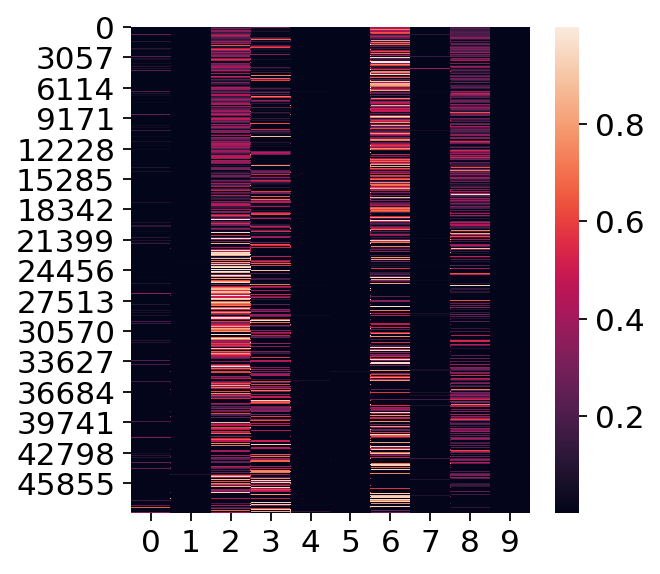

In [101]:
import seaborn
seaborn.heatmap(doc_topic)

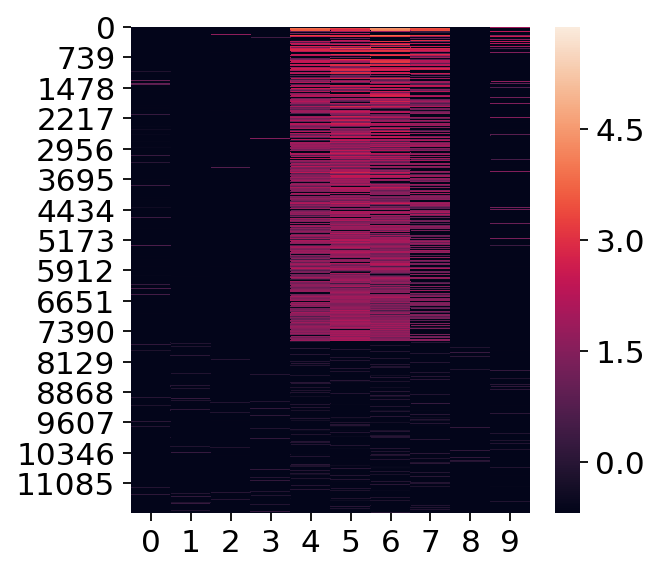

In [90]:
seaborn.heatmap(np.log10(ldaM.components_.T))

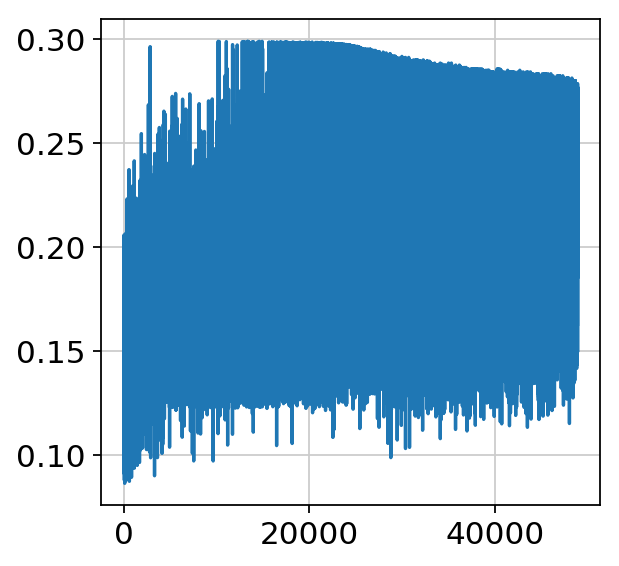

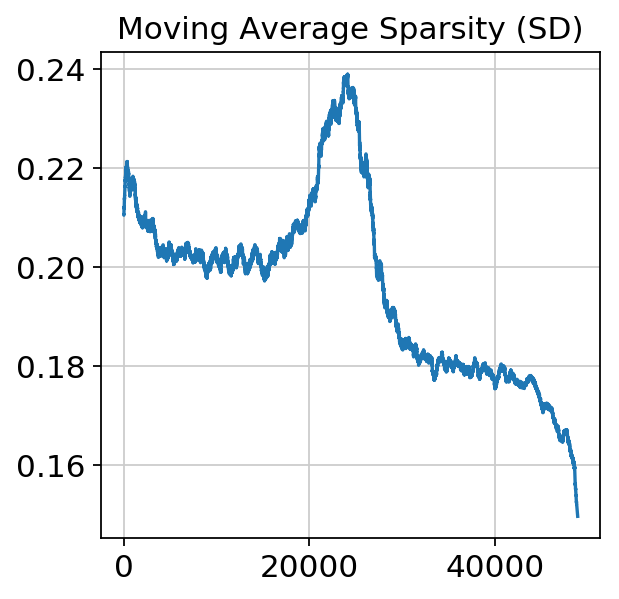

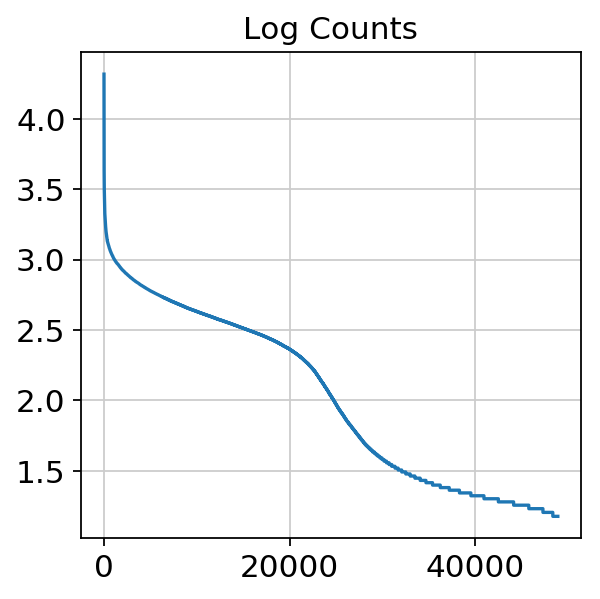

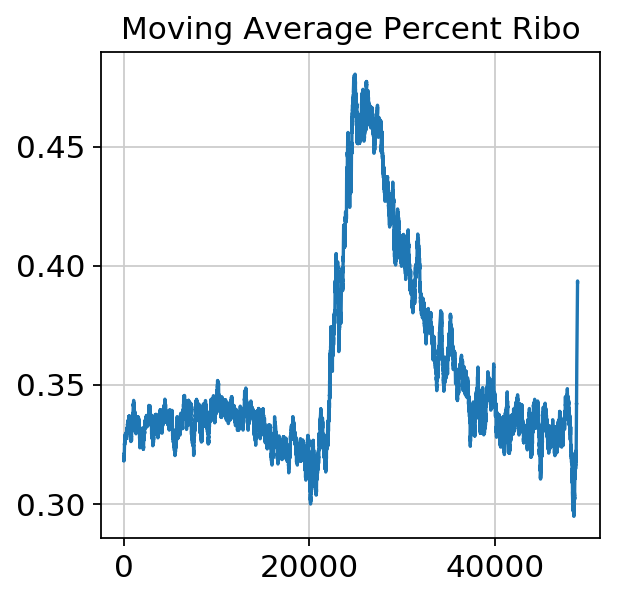

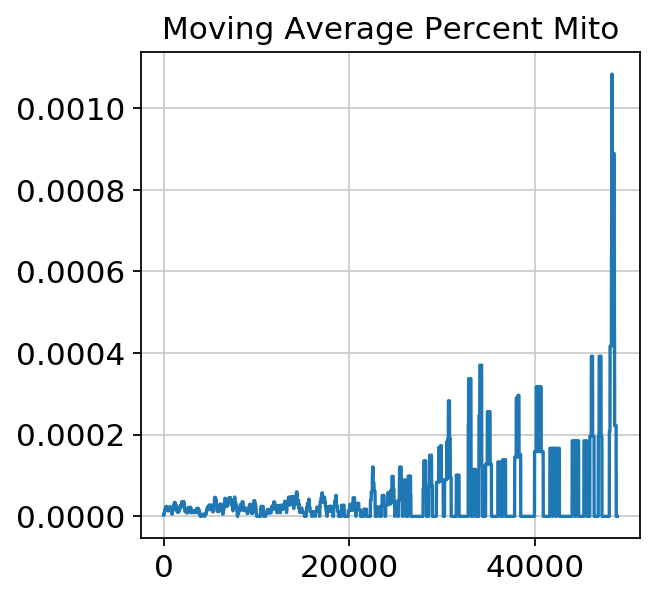

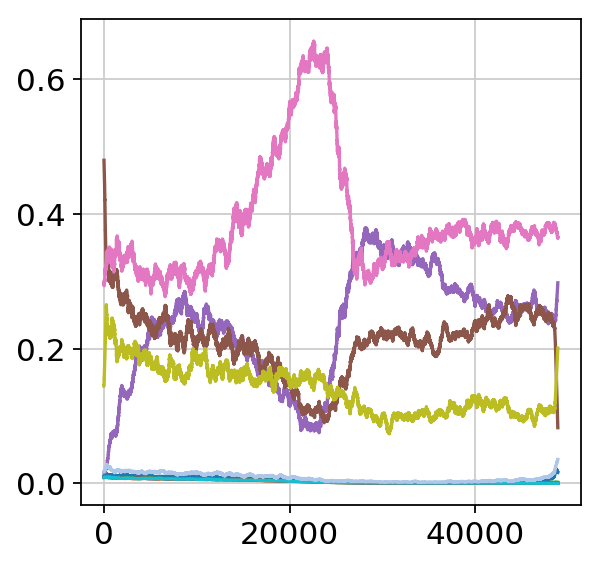

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


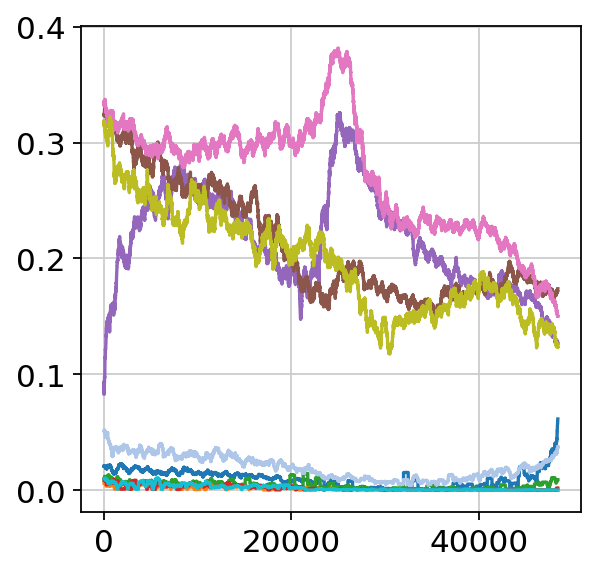

In [91]:
def moving_average(data,window_width):
    data_padded = np.pad(data, (window_width//2, window_width-1-window_width//2), mode='edge')
    cumsum_vec = np.cumsum(np.insert(data_padded, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return(ma_vec)

plt.plot(range(doc_topic.shape[0]),np.std( doc_topic,axis=1))
plt.show()
plt.xlabel
#convolvedSD=np.convolve(np.std( doc_topic,axis=1), np.ones((300,))/300, mode='valid')
convolvedSD=moving_average(np.std( doc_topic,axis=1),500)
plt.plot(range(len(convolvedSD)),convolvedSD[::-1])
plt.title("Moving Average Sparsity (SD)")
plt.show()
plt.plot(range(adata.obs.shape[0]),np.sort(np.log10(adata.obs.n_counts))[::-1])
plt.title("Log Counts")
plt.show()
convolvedSD=moving_average(adata.obs['percent_ribo'][adata.obs.n_counts.argsort()[::-1]].tolist(),300)
plt.plot(range(len(convolvedSD)),convolvedSD)
plt.title("Moving Average Percent Ribo")
plt.show()
convolvedSD=moving_average(adata.obs['percent_mito'][adata.obs.n_counts.argsort()].tolist(),300)
plt.plot(range(len(convolvedSD)),convolvedSD[::-1])
plt.title("Moving Average Percent Mito")
plt.show()

#plt.savefig()
for i in range(doc_topic.shape[1]):
    #convolve solution is slow...
    #convolved=np.convolve(doc_topic[:,i], np.ones((300,))/300, mode='valid')
    convolved=moving_average(doc_topic[:,i],500)
    plt.plot(range(len(convolved)),convolved[::-1])
plt.show()


for i in range(doc_topic.shape[1]):
    #convolve solution is slow...
    #convolved=np.convolve(doc_topic[:,i], np.ones((300,))/300, mode='valid')
    convolved=pd.rolling_std(doc_topic[:,i],window=500)
    plt.plot(range(len(convolved)),convolved[::-1])
plt.show()


In [92]:
print(adata)
print(doc_topic.shape)
for i in range(doc_topic.shape[1]):
    adata.obs['lda_'+str(i)]=doc_topic[:,i]

for i in range(ldaM.components_.shape[0]):
    adata.var['lda_'+str(i)]=ldaM.components_[i,:]
print(adata)


AnnData object with n_obs × n_vars = 48909 × 11817 
    obs: 'clean_obs_names', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'louvain'
    var: 'gene_ids', 'means', 'dispersions', 'dispersions_norm', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9'
    uns: 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_umap'
(48909, 10)
AnnData object with n_obs × n_vars = 48909 × 11817 
    obs: 'clean_obs_names', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'louvain'
    var: 'gene_ids', 'means', 'dispersions', 'dispersions_norm', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9'
    uns: 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_umap'


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def table_top_words(model, feature_names, n_top_words):
    df=[]
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx)
        df.append([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(df)
    return(pd.DataFrame(df).T)



print_top_words(ldaM,adata.var.index,15)
table_top_words(ldaM,adata.var.index,15).to_csv()

In [3]:
from sklearn import mixture
mix=sklearn.mixture.GaussianMixture(n_components=2)
mix.fit(doc_topic)
print(mix.predict(doc_topic))
plt.plot(moving_average(mix.predict(doc_topic),400))
plt.show()
plt.scatter(range(doc_topic.shape[0]),np.std( doc_topic,axis=1),c=mix.predict(doc_topic))
plt.show()
plt.hist2d(range(len(mix.predict(doc_topic))), mix.predict(doc_topic), (50, 50), cmap=plt.cm.jet)
plt.colorbar()
pd.Series(mix.predict(doc_topic)).value_counts()

NameError: name 'doc_topic' is not defined

In [11]:
import sys
def sc_hdp(adata,alpha=1,eta=.01,gamma=1,eps=.00001,save=False):
    import gensim
    from gensim import sklearn_api
    def moving_average(data,window_width):
        cumsum_vec = np.cumsum(np.insert(data, 0, 0))
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        return(ma_vec)
    def table_top_words(model, feature_names, n_top_words):
        df=[]
        for topic_idx, topic in enumerate(model.components_):
            print(topic_idx)
            df.append([feature_names[i]
                                for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(df)
        return(pd.DataFrame(df))

    #A bit of a hack because normally this is returned nice and sparse, but you don't know which topics are included
    def get_doc_topic(corpus, model,eps=0):
        doc_topic = list()
        for doc in corpus:
            doc_topic.append(model.__getitem__(doc, eps=eps))
        return np.array(doc_topic)[:,:,1]

    def get_topic_to_wordids(model):
        p = list()
        for topicid in range(model.m_T):
            topic = model.m_lambda[topicid]
            topic = topic / topic.sum() # normalize to probability dist
            p.append(topic)
        return np.array(p).T
    #Merges 2 2D dataframes into 3d, then collapses them every other column (Name1,Val1,Name2,Val2)
    def table_top_words(word_topic, feature_names):
        return(pd.DataFrame(np.stack([feature_names[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)))

    adata=adata[:,adata.var.index.argsort()]
    model = gensim.models.HdpModel(corpus=gensim.matutils.Sparse2Corpus( adata.X.T),id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),alpha=alpha,gamma=gamma,eta=eta)
    word_topic=get_topic_to_wordids(model)
    doc_topic=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)
    included_topics=np.sum(doc_topic,axis=0)/sum(np.sum(doc_topic,axis=0))>eps
    doc_topic=doc_topic[:,included_topics]
    word_topic=word_topic[:,included_topics]
    adata.uns['hdp_model']=model
    adata.varm['gene_topic']=word_topic
    adata.obsm['cell_topic']=doc_topic
    table_top_words(word_topic,adata.var.index).to_csv(os.path.join(sc.settings.figdir,"TopicMarkers.txt"))
    return(adata)
adata=sc_hdp(adata)
neighbors=sc.Neighbors(anndata.AnnData(adata.obsm['cell_topic']))
neighbors.compute_neighbors(n_neighbors=100,use_rep='X',metric="manhattan")
print("KNNed")
adata.uns['neighbors'] = {}
adata.uns['neighbors']['distances'] = neighbors.distances
adata.uns['neighbors']['connectivities'] = neighbors.connectivities
print(neighbors.distances)
print(neighbors.connectivities)
print('louvaining')
sys.stdout.flush()
sc.tl.louvain(adata)
#pd.DataFrame(adata.obs.groupby(['louvain','region']).size().unstack(fill_value=0)).to_csv(os.path.join(sc.settings.figdir,"RegionCluster.csv"))
print('umapping')
sys.stdout.flush()
sc.tl.umap(adata)
print('plotting')
sys.stdout.flush()
sc.pl.umap(adata,color=["louvain","percent_mito",'percent_ribo',"n_counts"])


adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(11817 unique tokens: ['A2M', 'A2ML1-AS1', 'AAAS', 'AADAT', 'AAGAB']...) from 1 documents (total 11817 corpus positions)


KeyboardInterrupt: 

In [53]:
#sc.tl.umap(adata)

#sc.pl.umap(adata,color=["louvain","percent_mito",'percent_ribo',"n_counts"])
np.sum(adata.obsm['cell_topic'],axis=1)


48909

In [30]:
import gensim
ldam=adata.uns['hdp_model'].suggested_lda_model()
def get_doc_topic(corpus, model,eps=0):
    print(corpus)
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
    return np.array(doc_topic)
dt=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),ldam)

#neighbors=sc.Neighbors(anndata.AnnData(adata.obsm['cell_topic']))
#neighbors.compute_neighbors(n_neighbors=100,use_rep='X')


using symmetric eta at 0.006666666666666667
using serial LDA version on this node


In [49]:
np.array(dt[0])[:,1]

array([3.58524130e-01, 3.05939584e-01, 4.11392319e-02, 2.13796840e-01,
       2.29243759e-02, 3.51450377e-02, 1.65111565e-02, 5.10658398e-03,
       1.84212468e-04, 8.67679313e-05, 2.97007718e-04, 3.02352638e-04,
       3.40684413e-05, 7.37740209e-07, 6.66790754e-07, 6.60633407e-07,
       5.34565399e-07, 4.27515970e-07, 4.64445843e-07, 3.81066041e-07,
       3.57966121e-07, 2.97709588e-07, 2.77905187e-07, 2.63432273e-07,
       2.67562931e-07, 2.51851271e-07, 2.70387802e-07, 1.50139283e-07,
       1.68103704e-07, 1.88137045e-07, 1.31985368e-07, 1.32215404e-07,
       1.26674978e-07, 1.40492819e-07, 1.20346814e-07, 1.15231173e-07,
       1.26276059e-07, 1.11734226e-07, 1.03669975e-07, 6.87213660e-08,
       5.17034067e-08, 2.61601906e-08, 1.10582701e-08, 1.30441347e-08,
       1.16915455e-08, 1.17942769e-08, 1.35398297e-08, 1.12380467e-08,
       1.34364024e-08, 1.45456360e-08, 1.46061998e-08, 1.47095272e-08,
       1.20438698e-08, 1.05303101e-08, 1.36215418e-08, 1.02635156e-08,
      

In [7]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
adata.var_names_make_unique()
print(adata.var.index)
print(adata.var.shape)
print(gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]))
print(gensim.matutils.Sparse2Corpus(adata.X.T))
adata=adata[:,adata.var.index.argsort()]

print(adata)
from gensim import sklearn_api
model = gensim.sklearn_api.HdpTransformer(id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),eta=.1)
distr = model.fit(gensim.matutils.Sparse2Corpus( adata.X.T))
#distr.gensim_model.get_topics()
#doc_topic2=distr.transform(gensim.matutils.Sparse2Corpus( adata[adata.obs.n_counts.argsort(),:].X.T))

#hdp=gensim.models.HdpModel(gensim.matutils.Sparse2Corpus( adata.X.T), gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]))

Index(['AAGAB', 'AAMP', 'AARS', 'ABCB7', 'ABCE1', 'ABHD18', 'ABI2', 'ABLIM1',
       'ABRACL', 'ABT1',
       ...
       'ZNHIT1', 'ZNHIT6', 'ZNRD1', 'ZPR1', 'ZRANB1', 'ZRANB2', 'ZRSR2',
       'ZSCAN16-AS1', 'ZSWIM7', 'ZUFSP'],
      dtype='object', length=3705)
(3705, 5)
adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(3705 unique tokens: ['AAGAB', 'AAMP', 'AARS', 'ABCB7', 'ABCE1']...) from 1 documents (total 3705 corpus positions)
Dictionary(3705 unique tokens: ['AAGAB', 'AAMP', 'AARS', 'ABCB7', 'ABCE1']...)
View of AnnData object with n_obs × n_vars = 3253 × 3705 
    obs: 'clean_obs_names', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts'
    var: 'gene_ids', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(3705 unique tokens: ['AAGAB', 'AAMP', 'AARS', 'ABCB7', 'ABCE1']...) from 1 documents (total 3705 corpus positions)
(0, '0.169*MALAT1 + 0.024*RPS27 + 0.023*RPL39 + 0.019*RPS19 

In [33]:
import seaborn
#seaborn.heatmap(doc_topic2[:,:])
seaborn.heatmap(hdp.get_topics().T[:,0:5])
np.sum(hdp.get_topics().T[:,0:5],axis=0)


NameError: name 'hdp' is not defined

In [67]:
trans= distr.transform(gensim.matutils.Sparse2Corpus(adata.X.T))
print(trans)
#distr = model.fit_transform(gensim.matutils.Sparse2Corpus( adata.X.T))
#tc=hdp[gensim.matutils.Sparse2Corpus( adata.X.T)]
print(tc.corpus.sparse.shape)
print(adata.X.shape[0])
topicUsed=[]
for x in range(len(tc)):
    print(x)
    topicUsed.append([y[0] for y in tc[x]])

#topicUsed=[y[0] for x in tc for y in x ]
print("iterated")
print(set(topicUsed))
#seaborn.heatmap(gensim.matutils.corpus2dense(tc,num_terms=adata.X.shape[0]))


[[0.74634427 0.25360754 0.         ... 0.         0.         0.        ]
 [0.67112213 0.3288278  0.         ... 0.         0.         0.        ]
 [0.75274163 0.02459772 0.         ... 0.         0.         0.        ]
 ...
 [0.9999181  0.         0.         ... 0.         0.         0.        ]
 [0.9752716  0.         0.02468772 ... 0.         0.         0.        ]
 [0.93818223 0.06178442 0.         ... 0.         0.         0.        ]]


NameError: name 'tc' is not defined

In [98]:
print(trans.shape)
print(distr.gensim_model.get_topics())
#adata.obsm['cell_topic']=np.array(trans2)[:,:,1]
from scipy import sparse
adata.uns['cell_topic'].todense()
#adata.uns['cell_topic']=scipy.sparse.csr_matrix(adata.obsm['cell_topic'])

(6119, 77)
[[1.84541144e-05 2.59031119e-05 4.14283061e-05 ... 1.70534135e-05
  1.71503468e-05 1.53456765e-05]
 [4.09341718e-05 2.64843869e-05 5.16363910e-05 ... 8.36384557e-06
  2.62305718e-05 1.11691528e-05]
 [2.83815603e-05 8.35117908e-05 7.38133533e-05 ... 2.19991996e-05
  9.76683164e-05 1.74825728e-05]
 ...
 [2.05002163e-04 4.12005756e-05 2.71373178e-05 ... 2.61177385e-04
  2.86492353e-04 9.77949345e-05]
 [1.85827326e-04 1.07654979e-04 9.67144258e-05 ... 5.12469886e-04
  1.46680325e-04 2.00087996e-04]
 [3.25637375e-04 1.18393425e-04 2.33472458e-04 ... 4.40585978e-04
  6.43114224e-04 1.72119396e-04]]


matrix([[6.02677992e-01, 8.49155569e-05, 3.10844914e-05, ...,
         4.50744847e-23, 2.25373152e-23, 2.25372666e-23],
        [8.57857253e-01, 7.09545853e-05, 2.59738883e-05, ...,
         3.76637861e-23, 1.88319539e-23, 1.88319133e-23],
        [7.31491989e-01, 8.00950231e-05, 2.93198696e-05, ...,
         4.25156712e-23, 2.12579043e-23, 2.12578585e-23],
        ...,
        [1.26994323e-01, 8.63162247e-01, 9.81911737e-03, ...,
         1.63769364e-23, 8.18849467e-24, 8.18847703e-24],
        [3.71151993e-01, 6.28789852e-01, 1.84457421e-05, ...,
         2.67474964e-23, 1.33737914e-23, 1.33737626e-23],
        [9.99218245e-01, 5.46699263e-05, 6.84002203e-04, ...,
         2.90196384e-23, 1.45098661e-23, 1.45098349e-23]])

In [8]:
def get_doc_topic(corpus, model,eps=0):
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
    return np.array(doc_topic)[:,:,1]

def get_topic_to_wordids(model):
    p = list()
    for topicid in range(model.m_T):
        topic = model.m_lambda[topicid]
        topic = topic / topic.sum() # normalize to probability dist
        p.append(topic)
    return np.array(p).T

def table_top_words(word_topic, feature_names):
    return(pd.DataFrame(np.stack([feature_names[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)))

doc_topic=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),distr.gensim_model)
word_topic= get_topic_to_wordids(distr.gensim_model)


In [19]:
print(adata.var.index[(-word_topic).argsort(axis=0)].shape)

#print(word_topic[(-word_topic).argsort(axis=0)][:,:,0].shape)
#Collate every other column
np.stack([adata.var.index[(-word_topic).argsort(axis=0)],word_topic[(-word_topic).argsort(axis=0)][:,:,0]],2).reshape(word_topic.shape[0],-1)

table_top_words(word_topic,adata.var.index)

(3705, 150)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,MALAT1,MALAT1,MALAT1,MALAT1,MALAT1,TTR,MALAT1,MALAT1,MALAT1,MALAT1,...,COPS6,SPAG7,NAA35,ZCCHC9,ARPC5,KRR1,USP39,MRPL17,Susie_Oran_G0051664,COPS6
1,RPS27,RPS27,TTR,FTL,TTR,MALAT1,TTR,RPS27,RPL39,TTR,...,NCL,POLR2K,DLGAP4,SEZ6L2,MTCH1,HADHA,BLCAP,PRPF38A,CTD-2659N19.10,CARD8
2,RPL39,RPL39,RPL39,RPS27,RPL39,FTL,RPS27,RPL39,RPS27,FTL,...,ACAT2,NDUFB1,TMEM74B,LYRM5,STK4,CXADR,PBDC1,NOL8,MSN,SRPRB
3,RPS19,RPS19,RPS27,RPL39,RPS27,RPS27,RPL39,RPS19,RPL41,RPL39,...,MIR4786,RAB13,SNAP29,PLGRKT,SEC11A,NDUFC1,ZNF790,POLR2L,PPM1B,TSTD1
4,RPL41,FTL,RPS19,RPL41,FTL,RPL39,RPS19,TTR,RPS19,RPS27,...,COX14,Susie_Oran_G0024417,SUZ12,ZNF706,CLIC1,RP11-330C7.3,SCHIP1,CDC37L1,FBLN1,ATP5G1
5,RPS3A,RPL41,RPL41,RPS19,RPS19,RPS19,RPL41,RPL41,FTL,NEAT1,...,COMMD3,ZNHIT1,BBS4,ADAR,CAPN9,WBP2,HNRNPH3,UGDH,DGUOK,PSAP
6,PTMA,RPS3A,FTL,RPS3A,RPL41,RPL41,FTL,PTMA,RPS3A,RPL41,...,ATP6V0E1,SRSF1,DNAJC9,ANK2,GORASP2,SCHIP1,NR2E1,FANCL,UGDH,NFYC
7,RPL32,RPL32,RPL32,AP000769.7,RPS3A,NEAT1,MT1E,RPS3A,RPL32,RPS19,...,BLMH,GRHPR,AZIN1,OXA1L,DDTP1,AIDA,GEMIN6,CLSTN1,PSME4,PLEKHA1
8,RPS14,RPS18,RPS14,RPL32,PTMA,CCK,RPS3A,RPL32,RPS18,FTH1,...,IKBIP,RPL39L,TRAPPC1,DNTTIP2,PLGRKT,MYNN,HAX1,ALDH9A1,RP11-372K14.2,FADS1
9,RPS18,RPS14,PTMA,RPS18,RPS14,FTH1,RPS14,FTL,TTR,RPL32,...,TRIM24,OTUD5,NUDCD2,NMRAL1,LCOR,TRIM28,PSMC5,ATXN3,UBE2V2,TMEM14A


In [78]:
def get_topic_to_wordids(model):
    p = list()
    for topicid in range(model.m_T):
        topic = model.m_lambda[topicid]
        topic = topic / topic.sum() # normalize to probability dist
        p.append(topic)
    return p 
np.array(get_topic_to_wordids(distr.gensim_model))

array([[ 1.83783694e-05,  2.58306387e-05,  4.13626516e-05, ...,
         1.69770533e-05,  1.70740293e-05,  1.52685663e-05],
       [ 3.99787882e-05,  2.54369561e-05,  5.07491821e-05, ...,
         7.20098437e-06,  2.51815241e-05,  1.00241618e-05],
       [ 2.41464746e-05,  8.07132386e-05,  7.07620881e-05, ...,
         1.75978081e-05,  9.52386422e-05,  1.29634911e-05],
       ...,
       [ 2.07970517e-04,  9.65971277e-06, -7.36634910e-06, ...,
         2.75980563e-04,  3.06628810e-04,  7.81771979e-05],
       [ 1.84753305e-04,  9.00706606e-05,  7.68194213e-05, ...,
         5.80384016e-04,  1.37338308e-04,  2.02025883e-04],
       [ 3.54183706e-04,  1.03027619e-04,  2.42490314e-04, ...,
         4.93488333e-04,  7.38929522e-04,  1.68137383e-04]])

In [81]:
word_topic_array=[]
for i in word_topic:
    mat=np.array(i[1])
    word_topic_array.append(mat[mat[:,0].argsort(),1])
word_topic_array=np.array(word_topic_array)
print(word_topic_array.shape)


(150, 7494)


In [23]:
def topic_prob_extractor(gensim_hdp):
    shown_topics = gensim_hdp.show_topics(num_topics=-1, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})
topic_prob_extractor(distr.gensim_model)
distr.gensim_model.get_topics().shape

NameError: name 'distr' is not defined

In [126]:
alpha=1
gamma=1
eta=.01
model = gensim.models.HdpModel(corpus=gensim.matutils.Sparse2Corpus( adata.X.T),id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),alpha=alpha,gamma=gamma,eta=eta)


adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(5238 unique tokens: ['AAAS', 'AAGAB', 'AAMP', 'AARS', 'AASDH']...) from 1 documents (total 5238 corpus positions)


KeyboardInterrupt: 

In [127]:
word_topic=get_topic_to_wordids(model)
doc_topic=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)


In [139]:
print(np.array(word_topic).shape)
print(np.array(doc_topic).shape)
np.max(np.array(doc_topic)[:,:,1],axis=0)>.005
np.array(word_topic).T.shape

(150, 5238)
(6119, 150, 2)


(5238, 150)

In [55]:
hdplda=distr.gensim_model.suggested_lda_model()

using symmetric eta at 0.006666666666666667
using serial LDA version on this node


In [56]:
doc_topic= hdplda.get_topics()

In [65]:
trans= hdplda[gensim.matutils.Sparse2Corpus(adata.X.T)]

In [29]:
trans=hdplda[gensim.matutils.Sparse2Corpus( adata.X.T)]

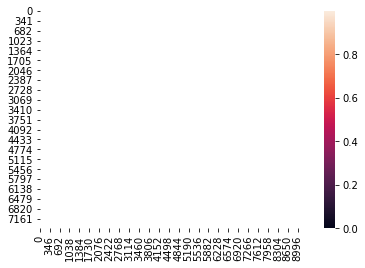

In [37]:
seaborn.heatmap(gensim.matutils.corpus2dense(trans,num_terms=adata.var.shape[0]))

In [22]:
#print(adata.var.index.tolist())
gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()])


adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(7494 unique tokens: ['A2M', 'AAAS', 'AADAT', 'AAGAB', 'AAK1']...) from 1 documents (total 7494 corpus positions)


In [24]:
gensim.matutils.Sparse2Corpus( adata.X.T)[300]

[(5510, 4.0),
 (3795, 1.0),
 (3393, 1.0),
 (5416, 6.0),
 (1357, 1.0),
 (4208, 1.0),
 (4697, 1.0),
 (139, 1.0),
 (3769, 2.0),
 (523, 1.0),
 (5243, 1.0),
 (300, 1.0),
 (7011, 2.0),
 (2181, 1.0),
 (676, 1.0),
 (997, 1.0),
 (3508, 1.0),
 (4170, 1.0),
 (5503, 1.0),
 (631, 1.0),
 (867, 1.0),
 (4325, 1.0),
 (5319, 1.0),
 (1528, 1.0),
 (5480, 5.0),
 (1558, 1.0),
 (3918, 1.0),
 (4158, 1.0),
 (3815, 1.0),
 (3814, 1.0),
 (6183, 2.0),
 (1896, 1.0),
 (5500, 1.0),
 (5270, 2.0),
 (6517, 1.0),
 (6697, 1.0),
 (5379, 1.0),
 (5431, 9.0),
 (3767, 1.0),
 (2053, 1.0),
 (2816, 1.0),
 (6219, 2.0),
 (2724, 1.0),
 (4983, 1.0),
 (5691, 1.0),
 (3019, 1.0),
 (555, 1.0),
 (6872, 3.0),
 (2591, 1.0),
 (2673, 2.0),
 (5875, 1.0),
 (2849, 1.0),
 (6853, 1.0),
 (6854, 2.0),
 (5415, 3.0),
 (5426, 1.0),
 (6783, 1.0),
 (1196, 1.0),
 (3773, 2.0),
 (227, 1.0),
 (6106, 1.0),
 (6521, 1.0),
 (3786, 1.0),
 (4621, 1.0),
 (5265, 1.0),
 (730, 1.0),
 (3273, 1.0),
 (266, 1.0),
 (417, 1.0),
 (6209, 1.0),
 (3582, 1.0),
 (5385, 1.0),
 (18

TypeError: get_document_topics() missing 1 required positional argument: 'bow'

In [9]:
import ruptures
import ruptures as rpt

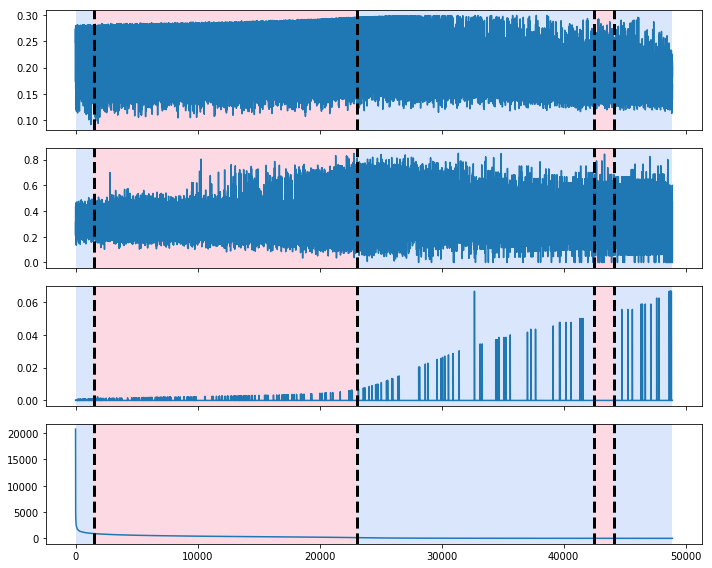

In [138]:
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)
#signal = np.column_stack((np.array(list(adata[adata.obs.n_counts.argsort()[::-1],:].obs.n_counts)),doc_topic))
signal = np.column_stack((moving_average(np.std( doc_topic,axis=1),500),
                          moving_average(adata.obs['percent_ribo'][adata.obs.n_counts.argsort()[::-1]].tolist(),500),
                          moving_average(adata.obs['percent_mito'][adata.obs.n_counts.argsort()[::-1]].tolist(),500),
                          np.array(list(adata[adata.obs.n_counts.argsort()[::-1],:].obs.n_counts))))

signal = np.column_stack((np.std( doc_topic,axis=1),
                          adata.obs['percent_ribo'][adata.obs.n_counts.argsort()[::-1]].tolist(),
                          adata.obs['percent_mito'][adata.obs.n_counts.argsort()[::-1]].tolist(),
                          np.array(list(adata[adata.obs.n_counts.argsort()[::-1],:].obs.n_counts))))

#signal = signal[0:40000,:]
# detection
algo = rpt.Window(width=3000,model="l2").fit(signal)
result = algo.predict(pen=50)

# display
rpt.display(signal=signal,true_chg_pts=result,computed_chg_pts= result)
plt.show()

In [139]:
print(signal.shape)
print(result)

(48909, 4)
[1500, 23060, 42495, 44140, 48909]


In [140]:
costs=[]
for i in range(len(result)-1):
    costs.append(algo.cost.sum_of_costs([result[i],result[len(result)-1]]))
print(costs)
np.argmin(costs)

[3530926039.3603845, 3028192152.4292665, 4972760633.011987, 5078049142.92726]


1

In [18]:
adata.uns['called']=['LDA','norm']
adata.uns['called']

['LDA', 'norm']

In [49]:
np.array(list(adata[adata.obs.n_counts.argsort(),:].obs.n_counts)).T

array([1.5000e+01, 1.5000e+01, 1.5000e+01, ..., 1.1439e+04, 1.3706e+04,
       2.0758e+04])

In [93]:
for i in range(doc_topic.shape[1]):
    adata.obs['lda_'+str(i)]=doc_topic[:,i]

for i in range(ldaM.components_.shape[0]):
    adata.var['lda_'+str(i)]=np.log10(ldaM.components_[i,:])


In [94]:
neighbors=sc.Neighbors(anndata.AnnData(np.array(adata.obs.loc[:,[x for x in adata.obs.keys() if "lda" in x]])))
neighbors.compute_neighbors(n_neighbors=100)
adata.uns['neighbors'] = {}
adata.uns['neighbors']['distances'] = neighbors.distances
adata.uns['neighbors']['connectivities'] = neighbors.connectivities

In [95]:
sc.tl.louvain(adata)
sc.tl.umap(adata)

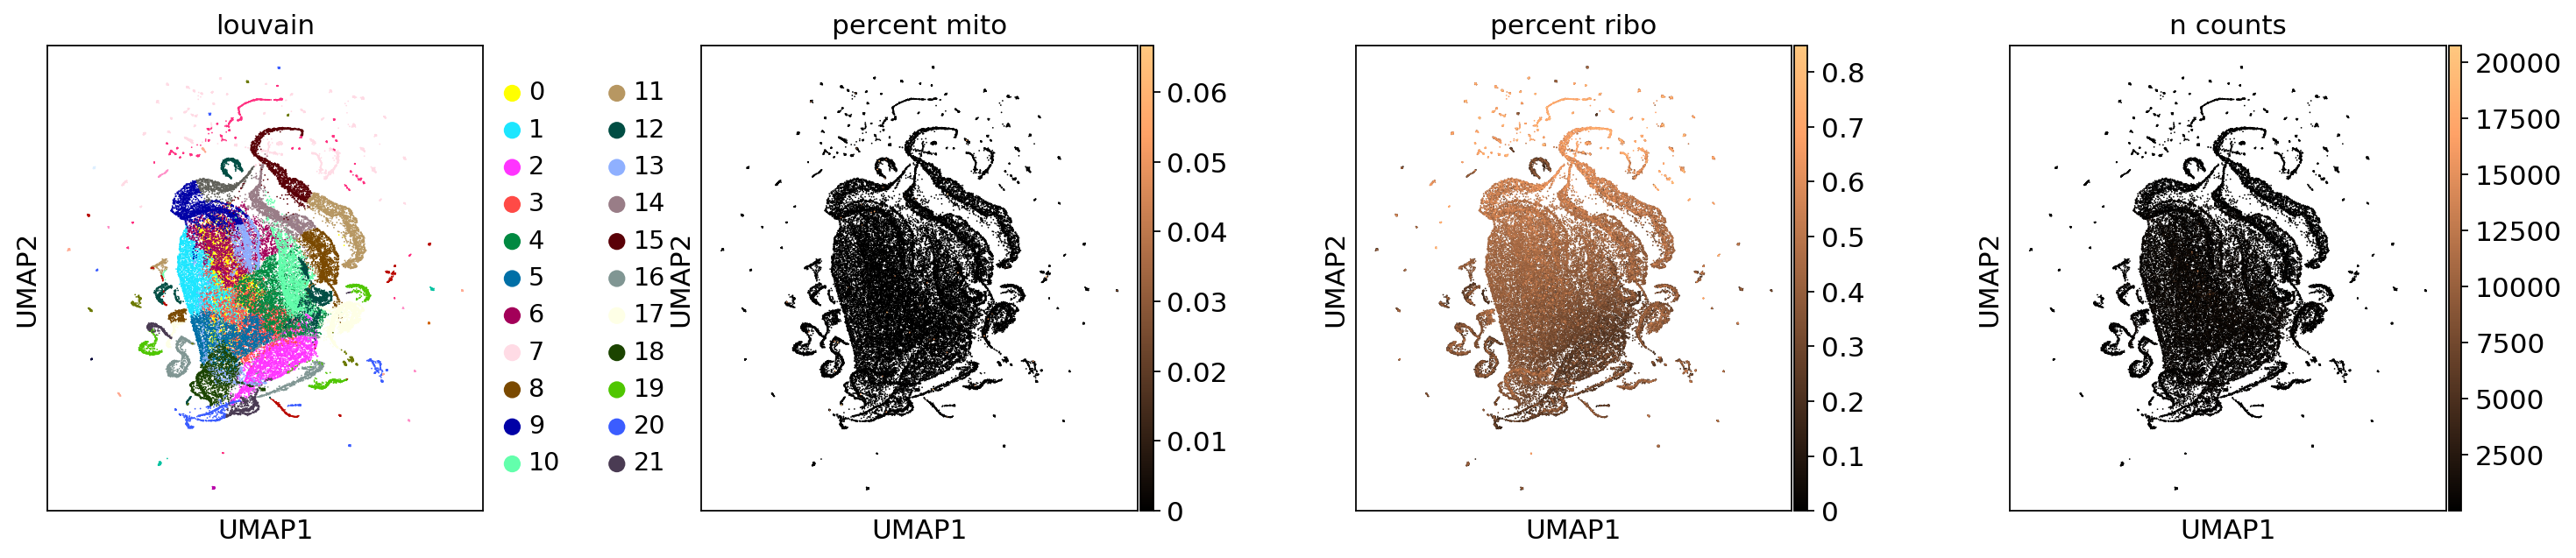

In [96]:
sc.pl.umap(adata,color=["louvain","percent_mito","percent_ribo","n_counts"])

In [97]:
sc.set_figure_params(color_map="copper")


In [62]:
neighbors.connectivities


<48909x48909 sparse matrix of type '<class 'numpy.float64'>'
	with 5825756 stored elements in Compressed Sparse Row format>

In [74]:
q=anndata.AnnData(np.array(adata.obs.loc[:,[x for x in adata.obs.keys() if "lda" in x]]))[20,:]

In [75]:
adata.obs.loc[adata.obs.index[20],np.array([x for x in adata.obs.keys() if "lda" in x])]

lda_0       0.253142
lda_1       0.131273
lda_2       0.119995
lda_3      0.0156883
lda_4    3.43879e-05
lda_5    3.43879e-05
lda_6    0.000378253
lda_7    3.43896e-05
lda_8       0.197451
lda_9       0.281969
Name: AGTCTTTAGGCTAGGT-1, dtype: object

In [83]:
adata.obs.region=[x.lower() for x in adata.obs.region]


In [84]:
adata.obs.lou

GCATGATCAGCTGCAC-1    gcatgatcagctgcac
GCCTCTATCAGCTCTC-1    gcctctatcagctctc
CTTTGCGAGACATAAC-1    ctttgcgagacataac
AACTCCCAGGGCATGT-1    aactcccagggcatgt
ACTGATGAGTTACCCA-1    actgatgagttaccca
GACTACAGTGCTAGCC-1    gactacagtgctagcc
CCGTACTGTTCCACGG-1    ccgtactgttccacgg
TACAGTGGTTCGTTGA-1    tacagtggttcgttga
GCCTCTAGTCCTAGCG-1    gcctctagtcctagcg
ACAGCCGGTCTGATTG-1    acagccggtctgattg
AAAGATGCAGCGAACA-1    aaagatgcagcgaaca
CAGTCCTGTCCAGTTA-1    cagtcctgtccagtta
CGCTGGATCGGACAAG-1    cgctggatcggacaag
TCCCGATAGGCACATG-1    tcccgataggcacatg
CTAAGACCAGTAGAGC-1    ctaagaccagtagagc
GCTTCCAGTACGAAAT-1    gcttccagtacgaaat
TACTCATGTGGGTATG-1    tactcatgtgggtatg
CAACCAATCAATCTCT-1    caaccaatcaatctct
GCAGCCAAGCCTTGAT-1    gcagccaagccttgat
CTCCTAGAGCGCCTTG-1    ctcctagagcgccttg
AGTCTTTAGGCTAGGT-1    agtctttaggctaggt
GAATGAAAGGACCACA-1    gaatgaaaggaccaca
CTCTGGTTCGGGAGTA-1    ctctggttcgggagta
CTAGTGACACAGGAGT-1    ctagtgacacaggagt
CGATGGCCAATGAAAC-1    cgatggccaatgaaac
AATCCAGAGGTGCACA-1    aat

ValueError: Neither the `x` nor `y` variable appears to be numeric.

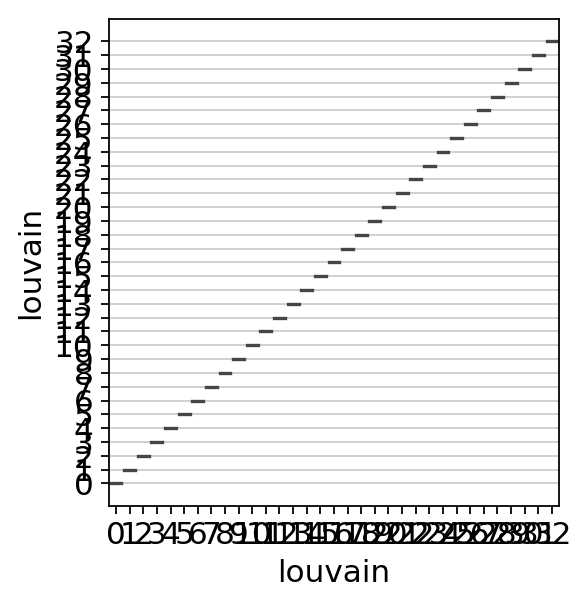

In [102]:
sc.pl.violin(adata,groupby="louvain",keys='louvain')

0.1 1.0 0.1
1.0 1.0 0.1
10.0 1.0 0.1
1.0 0.1 0.1
1.0 1.0 0.1
1.0 10.0 0.1
1.0 1.0 0.1
1.0 1.0 1.0
1.0 1.0 10.0


/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


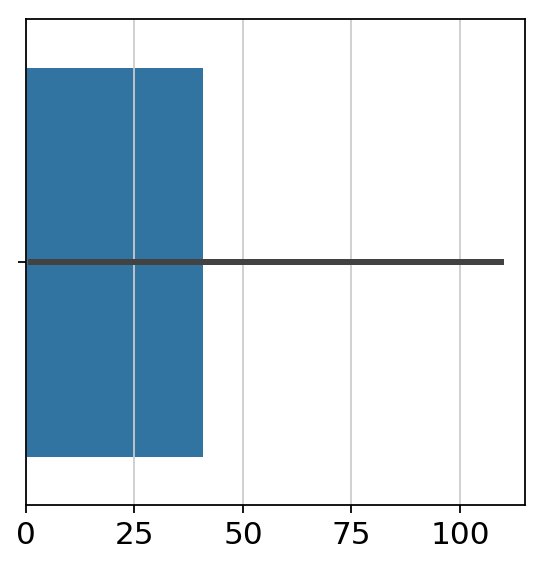

In [236]:
import numpy as np
defaults=[1,1,0]
v=[0.1,1,10]
test_condit=np.empty([len(v)*len(defaults),len(v)])
for i in range(len(v)):
    for j in range(len(defaults)):
        test_condit[(i*len(v)):((i+1)*len(v)),j]= v if i==j else  np.repeat(repeats=len(v),a=v[defaults[j]])

for i,j,k in test_condit:
    print(i,j,k)


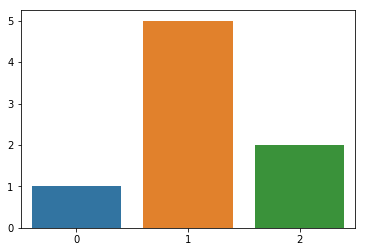

In [26]:
import seaborn
pl=seaborn.barplot(x=list(range(3)),y=[1,5,2])